[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
Training GRU-based RNN with Early Stopping:
Epoch 1/30 | Train Loss: 0.8952 | Valid Loss: 0.8793 | Valid Acc: 0.6729
Epoch 2/30 | Train Loss: 0.8947 | Valid Loss: 0.8807 | Valid Acc: 0.3271
Epoch 3/30 | Train Loss: 0.8945 | Valid Loss: 0.8836 | Valid Acc: 0.3271
Epoch 4/30 | Train Loss: 0.8946 | Valid Loss: 0.8802 | Valid Acc: 0.3271
Epoch 5/30 | Train Loss: 0.8944 | Valid Loss: 0.8794 | Valid Acc: 0.6729
Epoch 6/30 | Train Loss: 0.8942 | Valid Loss: 0.8798 | Valid Acc: 0.6729
Epoch 7/30 | Train Loss: 0.8944 | Valid Loss: 0.8801 | Valid Acc: 0.3271
Epoch 8/30 | Train Loss: 0.8940 | Valid Loss: 0.8814 | Valid Acc: 0.3271
Epoch 9/30 | Train Loss: 0.8944 | Valid Loss: 0.8793 | Valid Acc: 0.6729
Epoch 10/30 | Train Loss: 0.8940 | Valid Loss: 0.8807 | Valid Acc: 0.3271
Epoch 11/30 | Train Loss: 0.8943 | Valid Loss: 0.8808 | Valid Acc: 0.3271
Epoch 12/30 | Train Loss: 0.8940 | Valid Loss: 0.8839 | Valid Acc: 0.3271
Epoch 13/30 | Train Loss: 0.8943 | Valid Loss: 0.87

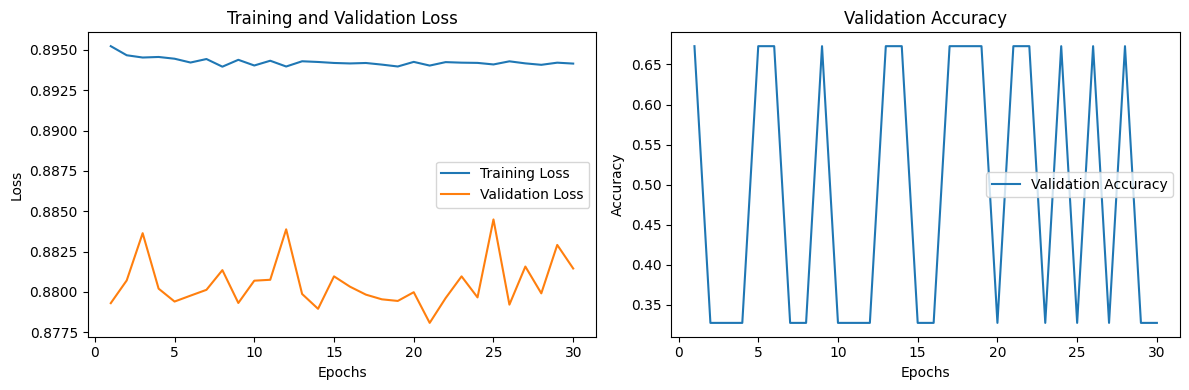


=== Test Results ===
Test Loss: 0.8928
Test Accuracy: 0.3544


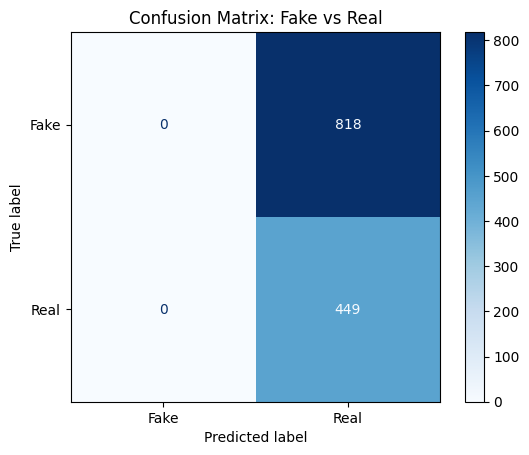

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv("/content/drive/My Drive/train.tsv", sep="\t", header=None)
valid_data = pd.read_csv("/content/drive/My Drive/valid.tsv", sep="\t", header=None)
test_data = pd.read_csv("/content/drive/My Drive/test.tsv", sep="\t", header=None)

columns = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party",
           "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]
train_data.columns = columns
valid_data.columns = columns
test_data.columns = columns

def binarize_label(label):
    return 1 if label in ["true", "mostly-true"] else 0

train_data["binary_label"] = train_data["label"].apply(binarize_label)
valid_data["binary_label"] = valid_data["label"].apply(binarize_label)
test_data["binary_label"] = test_data["label"].apply(binarize_label)
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    return [word for word in words if word not in stop_words]
statements = train_data["statement"].apply(preprocess_text)
all_words = [word for statement in statements for word in statement]
word_counts = Counter(all_words)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(5000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def text_to_indices(text, vocab, max_len=70):
    words = preprocess_text(text)
    indices = [vocab.get(word, vocab["<UNK>"]) for word in words[:max_len]]
    if len(indices) < max_len:
        indices += [vocab["<PAD>"]] * (max_len - len(indices))
    return indices
train_data["indices"] = train_data["statement"].apply(lambda x: text_to_indices(x, vocab))
valid_data["indices"] = valid_data["statement"].apply(lambda x: text_to_indices(x, vocab))
test_data["indices"] = test_data["statement"].apply(lambda x: text_to_indices(x, vocab))

class LIARDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = torch.tensor(indices, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.indices[idx], self.labels[idx]
train_dataset = LIARDataset(train_data["indices"].tolist(), train_data["binary_label"].tolist())
valid_dataset = LIARDataset(valid_data["indices"].tolist(), valid_data["binary_label"].tolist())
test_dataset = LIARDataset(test_data["indices"].tolist(), test_data["binary_label"].tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class FakeNewsGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(FakeNewsGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        _, hidden = self.gru(embedded)
        hidden = hidden[-1]
        hidden = self.dropout(hidden)
        return self.fc(hidden)
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeNewsGRU(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
num_pos = train_data["binary_label"].sum()
num_neg = len(train_data) - num_pos
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def train_and_evaluate(model, train_loader, valid_loader, epochs=30, patience=999):
    best_val_loss = float('inf')
    counter = 0
    best_model = None
    train_losses, valid_losses, valid_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for texts, labels in valid_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts).squeeze(1)
                valid_loss += criterion(predictions, labels).item()
                predicted = (torch.sigmoid(predictions) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct / total
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")
        if avg_valid_loss < best_val_loss:
            best_val_loss = avg_valid_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            total_loss += criterion(predictions, labels).item()
            predicted = (torch.sigmoid(predictions) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n=== Test Results ===")
    print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    print(f"Test Accuracy: {correct / total:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix: Fake vs Real")
    plt.show()

print("Training GRU-based RNN with Early Stopping:")
train_and_evaluate(model, train_loader, valid_loader, epochs=30, patience=999)
evaluate_test(model, test_loader)
torch.save(model.state_dict(), "gru_final_model.pth")